# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

## Using python 2.7.13 and sklearn 0.17.1

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
from __future__ import division

# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# DONE: Total number of records
n_records = data.shape[0]

# DONE: Number of records where individual's income is more than $50,000
n_greater_50k = data[data.income == '>50K'].shape[0]

# DONE: Number of records where individual's income is at most $50,000
n_at_most_50k = n_records - n_greater_50k

# DONE: Percentage of individuals whose income is more than $50,000
# Note: utilizing __future__ division previously imported
greater_percent = n_greater_50k / n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 0.25%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

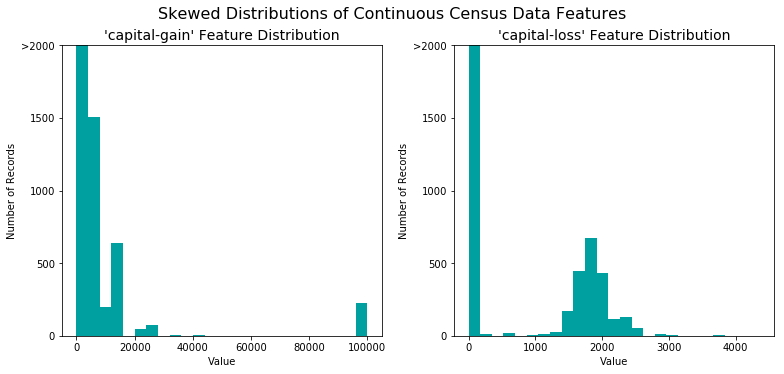

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

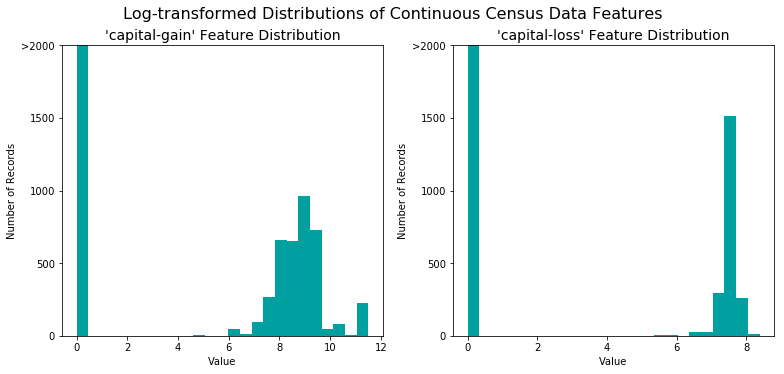

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# DONE: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# DONE: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
from sklearn.metrics import precision_recall_fscore_support


income_pred = np.ones(n_records)

# DONE: Calculate accuracy
accuracy = n_greater_50k / n_records

# DONE: Calculate F-score using the formula above for beta = 0.5
beta = 0.5

# fscore aquired by sklearn
sklearn_precision, sklearn_recall, sklearn_fscore, sklearn_support = precision_recall_fscore_support(income.values, income_pred, beta, average='binary')

# fscore manually aquired
tp = np.logical_and(income.values == 1, income_pred == 1).astype(int).sum()
fp = np.logical_and(income.values == 0, income_pred == 1).astype(int).sum()
fn = np.logical_and(income.values == 1, income_pred == 0).astype(int).sum()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
fscore = (1 + beta ** 2) * precision * recall / (beta ** 2 * precision + recall)

# I added a f1-score calculation in case the project rubric was actually correct in
# asking the student to calculate it (https://review.udacity.com/#!/rubrics/406/view)
f1score = 2 * precision * recall / (precision + recall)

# I got the same results
assert(precision == sklearn_precision)
assert(recall == sklearn_recall)
assert(fscore == sklearn_fscore)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F0.5-score: {:.4f}, F1-score: {:.4f}]".format(accuracy, fscore, f1score)

Naive Predictor: [Accuracy score: 0.2478, F0.5-score: 0.2917, F1-score: 0.3972]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

# Answer:

**About my three choices**

I choose SVM, SGDC and Gradient boosting in order to learn a set of somewhat complementary tools that I found interesting. I chose SVM as I understand them to be applied quite generally, for example [4] recommends using them with datasets less than 100k entries. For larger datasets SGDC is recommended [4], and I like that you could, as far as i understand it, utilize SGDC for incremental learning, and that might be very relevant for a personal use case I have in mind. And finally I choose gradient boosting since I was enthralled by how similar the train/test learning curves behaves with a growing sum of weak learner contributions.

## 1: Support Vector Machines (SVM)

**Described use case **

I read about a SVM-classifier being implemented to improve the behaviour of an industry robot in the situations some error had arisen. It was meant to improve the current too simple behaviour of first letting go of any held parts in a scrap station and then returning to a home position. They wanted the SVM-classifier to decide if it should do one of four things instead: 1) go home, 2) scrap a held part and then go home, 3) drop a held part and then go home, and 4) stop and wait for human intervention.

The features used in order to decide on the error recovery behaviour was in summary: location, gripping tool status, and procedure status. The feature space contained 432 combinations, and the goal was to show the robot as few examples as possible in order of a preferred error recovery behaviour (1-4) in that feature space, and let the SVM generalize from that.

They key to reach 100% accuracy, which was plausible in this case, in as short time as possible was said to be choosing good training examples. With cleverly chosen training examples they could achieve 100% accuracy after training on 1/16 of the feature space compared to about 1/4 of the feature space.


**Strengths** 

+ Generalize even without much data [1, p.2].
+ SVM models (hard/soft margins), are convex optimization problems, and this implies that any local minima you find is also a global minima [3].


**Weaknesses**

- Have multiple parameters to set, such as a kernel choice and additional parameters associated with the kernel. This means that a grid search cross validation over the parameters is likely to be essential.
- Does not handle noise well [3].
- Does not scale to large datasets so well [3], a size less than 100k is recommended [4].
- Does not seem to be suitable for incremental learning [5].


**Model selection**

Is feature space complicated, but you believe there to be a clear margin of separation? Go SVM!
Is the dataset very large (+100k), or have a lot of noise? Perhaps keep looking at alternatives to SVM.
Will your dataset grow incrementally? Then SVM's might not be the way to go.


**References**

[1] Lau, Cidney (2015) - Support Vector Machine Algorithm applied to Industrial Robot Error Recovery
http://kth.diva-portal.org/smash/get/diva2:846825/FULLTEXT01.pdf

[2] SVM Strengths and Weaknesses, a video summary from the Udacity course ud120: Intro to Machine Learning.
https://www.youtube.com/watch?v=U9-ZsbaaGAs

[3] Stack overflow question response: "Does SVM classification always produces unique solution?"
https://stackoverflow.com/a/12610455/2220152

[4] Choosing the right estimator - Scikit-learn
http://scikit-learn.org/stable/tutorial/machine_learning_map/

[5] Stack overflow question response: "A few implementation details for a Support-Vector Machine (SVM)"
https://stackoverflow.com/questions/3446622/a-few-implementation-details-for-a-support-vector-machine-svm

## 2: Stochastic Gradient Descent Classifier (SGDC)

**Note about SGD vs SGDC**

SGD is a technique, and SGDC is utilizing SGD in conjunction with for example a SVM classifier in order to perform supervised classification. My discussion focuses mainly on SGD itself.


**Described use case **

It was phrased to be the "de facto standard"[1] for adjusting the weights in artificial neural networks during backpropagation,  was a phrasing used. Perhaps it is due to ANN's complexity has no upper limit, and it could often be too computationally expensive in order to account for the full dataset [5]. Also, perhaps ANN often are provided with incremental data [pure speculation].

I wondered if AlphaGo's used SGD, but I failed to find out. I can wait for the future parts of this course in order to find out more about that.


**Strengths** 

+ Less prone to lead to local minima than normal gradient descent [6, p.2].
+ Suitable for very large datasets, since not all data need to be processed in each iteration [2].
+ Descend towards a minima with a lot less computational effort than normal gradient descent [\*][2].
+ Can efficiently be used for incremental learning [2].
+ Does not require tuning of a fixed step size, but you still have some tuning to do.


**Weaknesses**

- Does not ensure that each iteration decreases the error as normal GD does [\*].
- Can require feature scaling, since the step size can be too large in certain dimensions and too small in others [\*].


**Model selection**

In general, if you would benefit from the strengths and are not worried about the weaknesses, then SGDC would be useful. For example if you know you have a massive dataset, larger than 100k of training examples for example [4], you could benefit from utilizing SGD. I wanted it in my toolset especially because it enables incremental learning.


**References**

[\*] My own confident understanding of how things work, based on this course's video lectures mainly.

[1] Wikipedia: Stochastic Gradient Descent #Applications.
https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Applications

[2] Coursera course: Machine Learning, with Andrew Ng, on the topic "Gradient Descent with Large Datasets"
https://www.coursera.org/learn/machine-learning/lecture/CipHf/learning-with-large-datasets

[3] Yann LeCun et. al. (1998) - Effient BackProp
http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf

[4] Choosing the right estimator - Scikit-learn
http://scikit-learn.org/stable/tutorial/machine_learning_map/

[5] Optimization: Stochastic Gradient Descent
http://ufldl.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/

[6] Bottou, Léon - Stochastic Gradient Learning in Neural Networks (1991)
http://leon.bottou.org/publications/pdf/nimes-1991.pdf


## 3: Gradient Boosting

**Background**

Gradient boosting is commonly used together with decision trees (GBDT), so is the Random forest (RF) technique. Both techniques are combining simpler decision trees in order to form a better hypothesis. Scikit-learn's Gradient Boosting can only utilize decision tree's as weak learners as far as I understand it.


**Described use case **

Search engines use it for web page ranking [5] apparently.


**Strengths** 

+ GBDT does not require you to figure out non-linear feature interactions [5, 7 min in].
+ You can inspect how a GBDT work better than you can with ANN [5, 8 min in and 28 min in]
+ GBDT can function well without feature normalization [5, 7 min in]
+ Can support different loss functions [5, 7 min in], but I don't yet understand the power that this entails.
+ It can be utilized in conjuction with various models, not only decision trees even though DT is the norm [1].
+ Reduces overfitting issues. In the case of using decision trees, one might greatly overfit the training data since it makes firm decision boundaries, gradient boosting weights together many decision trees making these boundaries fuzzier [2].
+ Empirically found to be a compete well against other algorithm for general problems in Kaggle competitions [2].
+ Better performance on GBDT than RF [3].


**Weaknesses**

- GBDT requires careful tuning of parameters [5, 7 min in]
- GBDT are often computationally more expensive than RF [3].
- GBDT cannot extrapolate, in other words: GBDT cannot draw conclusions outside the training data, only in between it.


**Model selection**

I currently understand it as GBDT can't extrapolate from, so if that is required, do not choose GBDT. Other than that, GBDT seems to be a good all round model that is beaten mainly by techniques niched for certain use cases.


**References**

[1] Wikipedia: Gradient boosting
https://en.wikipedia.org/wiki/Gradient_boosting

[2] Gorman, Ben (2017) - A Kaggle Master Explains Gradient Boosting
http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/

[3] Quora Answer - What are the advantages/disadvantages of using Gradient Boosting over Random Forests?
https://www.quora.com/What-are-the-advantages-disadvantages-of-using-Gradient-Boosting-over-Random-Forests

[4] Choosing the right estimator - Scikit-learn
http://scikit-learn.org/stable/tutorial/machine_learning_map/

[5] Peter Prettenhofer - Gradient Boosted Regression Trees in scikit-learn
https://www.youtube.com/watch?v=IXZKgIsZRm0


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# DONE: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.utils import resample

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # DONE: Fit the learner to the training data using slicing with 'sample_size'
    X_train, y_train = resample(X_train, y_train, n_samples=sample_size, random_state=0)
    
    start = time() # Get start time
    learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # DONE: Calculate the training time
    results['train_time'] = end - start
        
    # DONE: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # DONE: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # DONE: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    # DONE: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # DONE: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta)
        
    # DONE: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

In [10]:
# DONE: Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


# DONE: Initialize the three models
# Note: Default parameters used (except for random_state=0), but written out explicitly for my own reference
clf_A = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=0)
clf_B = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, n_iter=5, shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=0, learning_rate='optimal', eta0=0.0, power_t=0.5, class_weight=None, warm_start=False, average=False)
clf_C = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, init=None, random_state=0, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
clf_D = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=0, max_leaf_nodes=None, class_weight=None, presort=False)
clf_E = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=0, verbose=0, warm_start=False, class_weight=None)
clf_F = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=0, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)
clf_G = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1)
clf_H = GaussianNB()


# DONE: Calculate the number of samples for 1%, 10%, and 100% of the training data
total_samples = X_train.shape[0];
samples_1 = int(np.ceil(total_samples * 0.01))
samples_10 = int(np.ceil(total_samples * 0.1))
samples_100 = int(np.ceil(total_samples * 1))

# Collect results on the learners
def collect_results(clfs):
    results = {}
    for clf in clfs:
        clf_name = clf.__class__.__name__
        results[clf_name] = {}
        for i, samples in enumerate([samples_1, samples_10, samples_100]):
            results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
    return results

# Run metrics visualization for the three supervised learning models chosen
all_results = collect_results([clf_A, clf_B, clf_C, clf_D, clf_E, clf_F, clf_G, clf_H])

C:\Programs\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 362 samples.
SVC trained on 3618 samples.
SVC trained on 36177 samples.
SGDClassifier trained on 362 samples.
SGDClassifier trained on 3618 samples.
SGDClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 362 samples.
GradientBoostingClassifier trained on 3618 samples.
GradientBoostingClassifier trained on 36177 samples.
DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.
RandomForestClassifier trained on 362 samples.
RandomForestClassifier trained on 3618 samples.
RandomForestClassifier trained on 36177 samples.
LogisticRegression trained on 362 samples.
LogisticRegression trained on 3618 samples.
LogisticRegression trained on 36177 samples.
KNeighborsClassifier trained on 362 samples.
KNeighborsClassifier trained on 3618 samples.
KNeighborsClassifier trained on 36177 samples.
GaussianNB trained on 362 samples.
GaussianNB trained on 3618 samples.
GaussianNB 

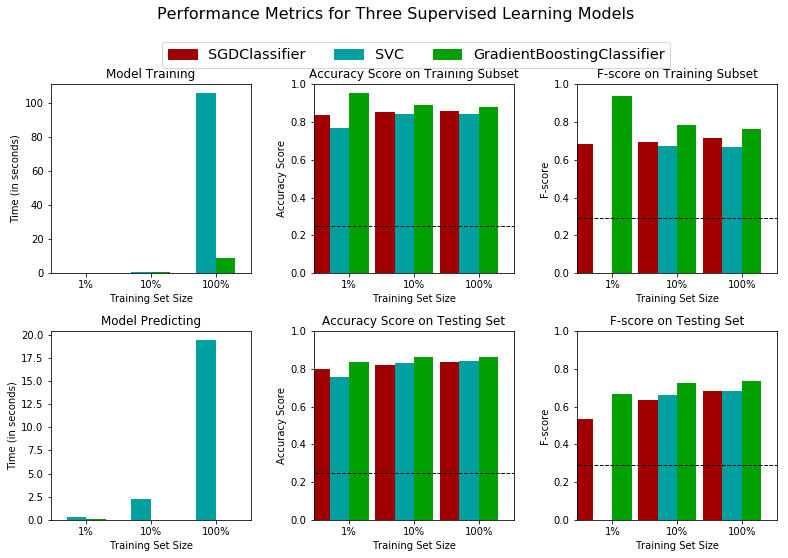

In [11]:
# Circumvent provided code's restriction of only showing three models
def filter_results(clfs):
    return {k:v for k,v in all_results.iteritems() if k in [clf.__class__.__name__ for clf in clfs]}

results_limit_3 = filter_results([clf_A, clf_B, clf_C]);

vs.evaluate(filter_results([clf_A, clf_B, clf_C]), accuracy, fscore)
#vs.evaluate(filter_results([clf_D, clf_E, clf_F]), accuracy, fscore)
#vs.evaluate(filter_results([clf_G, clf_H]), accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

In [12]:
import pandas as pd

data = np.array([
    [round(all_results[k][2]['f_test'], 2) for k in results_limit_3.iterkeys()],
    [round(all_results[k][2]['acc_test'], 2) for k in results_limit_3.iterkeys()],
    [round(all_results[k][2]['train_time'], 2) for k in results_limit_3.iterkeys()],
    [round(all_results[k][2]['pred_time'], 2) for k in results_limit_3.iterkeys()],
])

print(pd.DataFrame(data, ['F-score', 'Accuracy', 'Train time', 'Prediction time'], results_limit_3.iterkeys()))

                 SGDClassifier     SVC  GradientBoostingClassifier
F-score                   0.68    0.68                        0.74
Accuracy                  0.84    0.84                        0.86
Train time                0.10  105.93                        9.00
Prediction time           0.01   19.46                        0.03


**Answer: **

Comparing the metrics of the default parameterisation of the three models: SVC, SGDClassifier and GradientBoostingClassifier, I find SVC to be the obvious looser. Note that the SGDC utilizes a linear SVM.

I deem the booster to be the preferred choice based on the metrics, even though the SGDC is a quicker learner and predicter, that is not so essential. The dataset I have to work with is finite and spending about ten seconds for the training of the booster is acceptable. The F-score seems to me as the most important consideration, and the boosters F-score (0.74) beats the SGDC (0.68)

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **

My chosen model (GBC) combines simpler models (DT) in a smart and efficient way, where every combined simpler model is meant to augment the model to fix it's previous key issues.

The final model functions like a democracy of people standing in a line, where the formost persons voice will be strongest, but all voices are still heard. Also, every person in the line is trained to knows and care more or less about various topics, the combination of their opinions will represent a weigh in of core principles rather than a single experts knowledge of a given set of circumstances. This makes the final model generalize to new data!

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [20]:
# Notes:
# I will follow a tuning recipe for tuning this classifier [1].
# The recipe has three steps.
# - 1: Set n_estimators as high as possible
# - 2: Tune hyperparameters
# - 3: Iterate recipe with a higher n_estimators and tune the learning_rate
#
# Technical details
# --- max_depth usually between 4-6 [1]
# --- lowering learning_rate should go hand in hand with increasing n_estimators
#
# Reference:
# [1] Peter Prettenhofer - Gradient Boosted Regression Trees in scikit-learn
# https://www.youtube.com/watch?v=IXZKgIsZRm0&t=23m7s

# DONE: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

# DONE: Initialize the classifier
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

In [21]:
# DONE: Create the parameters list you wish to tune
# NOTE: This is the final run of the grid search, I have already tuned n_estimators and learning_rate a bit
param_grid = {
    'n_estimators': [300],
    'learning_rate': [0.07, 0.075, 0.08],
    'max_depth': [3,4,5],
    'min_samples_leaf': [4,5,6],
    'max_features': [1.0],
}

# DONE: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=beta)

# DONE: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid, scoring=scorer, n_jobs=4)

# DONE: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator and best params (based on the training data only)
best_clf = grid_fit.best_estimator_
best_clf_params = grid_fit.best_params_

# Make using the unoptimized and model
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta=beta))
print "Params: {'max_features': 1.0, 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1}"
print 
print "Optimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=beta))
print
print 'Params:', best_clf_params

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395
Params: {'max_features': 1.0, 'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1}

Optimized Model
------
Final accuracy score on the testing data: 0.8713
Final F-score on the testing data: 0.7538

Params: {'max_features': 1.0, 'n_estimators': 300, 'learning_rate': 0.08, 'max_depth': 4, 'min_samples_leaf': 5}


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptim. | Optim. 1 | Optim. 2 | Optim. 3 | Optim. 4 | Optim. 5 | **Optim. 6** |
| :------------: | :-----------------: | :------: | :------: | :------: | :------: | :------: | :------: | :------:     |
| Accuracy Score | 0.2478              | 0.8630   | 0.8695   | 0.8715   | 0.8708\* | 0.8718   | 0.8700\* | **0.8713**   |
| F_0.5-score    | 0.2917              | 0.7395   | 0.7500   | 0.7532   | 0.7519\* | 0.7546(!)| 0.7500\* | **0.7538**   |
|                |                     |          |          |          |          |          |          |              |
| *n_estimators* | -                   | 100      | 100      | 300      | 600      | 300      | 300      | **300**      |


**Answer: **

The score in our grid search was cross validated using partitions of the training data, so by chance, the best candidate presented from a grid search could have a lower F-score than the default parameterisation on the testing data. This was something I concluded when a grid search on a subset of a larger *param_grid* found better result than the grid search on the full *param_grid* (Optim. 4 used a *learning_rate* of 0.075 and got better results on the test set, while Optim. 6 had a *learning_rate* of 0.075 in it's *param_grid*, a *learning_rate* of 0.08 was chosen as the optimal, but ended up with a lower test score).

I followed a suggested recipe for tuning the hyperparameters [1], after some iterations of grid searches, I end up with a result that was very similar to the first grid search optimization. The F-score went from 0.7500 to 0.754.

The biggest F-score improvement was to go from benchmark predictor (0.292) to an unoptimized gradient boosting model (0.750). The following optimizations led only to a slight improvement (0.754).

**Mentioned recipe:**
- 1: Set n_estimators as high as possible
- 2: Tune hyperparameters
- 3: Iterate recipe with a higher n_estimators and tune the learning_rate

**Reference:**

[1] Peter Prettenhofer - Gradient Boosted Regression Trees in scikit-learn - 23 minutes and 7 seconds in.
https://www.youtube.com/watch?v=IXZKgIsZRm0&t=23m7s

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

In [28]:
# Display the first five records
display(pd.read_csv("census.csv").head(n=30))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


**Answer:**

Assuming I should make a prediction before I actually look at the *feature_importances_* this seems really tough. I looked at 30 entries and tried to find patterns and explain them: I believe the following might be the most important features:

1. **capital-gain** - 2/3 with a capital gain > 0 had a >50k income, and the correlation seems plausible.
2. **education-num** - You have a higher education, you probably manage to get jobs with higher incomes.
3. **hours-per-week** - You work more, you gain more.
4. **age** - You've had time to advance the carreer ladder
5. **workclass** - I figure the private sector can give better pay.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

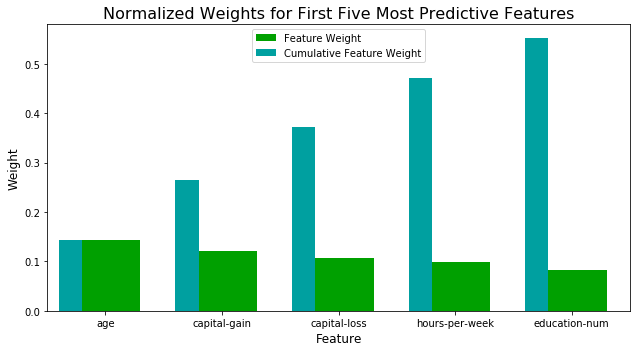

In [29]:
# DONE: Import a supervised learning model that has 'feature_importances_'
# DONE: Train the supervised model on the training set 
# NOTE: My GradientBoostClassifier is already imported and trained
model = best_clf

# DONE: Extract the feature importances
importances = best_clf.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

I got 4/5 right, but not in the right order. I had **workclass** instead of **capital-loss** on my top 5 list. I had soo few examples of a non-zero *capital-loss* in the first 30 datapoints I looked at, and *capital-loss* would probably predict a <=50k income which was already quite likely in comparison to a >50k income.

That **Age** was the most important factor did not surprise me, since it really makes sense that it has a positive correlation with income, and should do that with som random variations for each individual.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [32]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
stop = time()
time_reduced = stop - start

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)



# Train on the "best" model found from grid search earlier, with all features again for a time comparison
start = time()
clf = (clone(best_clf)).fit(X_train, y_train)
stop = time()
time_not_reduced = stop - start



# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=beta))
print "Training time: {:.1f}".format(time_not_reduced)
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta=beta))
print "Training time: {:.1f}".format(time_reduced)

Final Model trained on full data
------
Accuracy on testing data: 0.8713
F-score on testing data: 0.7538
Training time: 35.6

Final Model trained on reduced data
------
Accuracy on testing data: 0.8428
F-score on testing data: 0.7007
Training time: 4.0


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

We'll this went a lot quicker, actually it reduced the time by about 90%. This could enable me to use an even higher number of the *n_estomators* parameter along with a lower *training_time*. Will the F-score improve, holding the training time fixed? The F-score dropped from about 0.75 to 0.70 with the reduced feature set, and the time reduction was 90%, how much better will the F-score become with a higher number of *n_estimators*?

**Spoiler to my question below:**

It did no better at all doh! The grid search actually gave a slightly lower F-score on the test data ^^

In [34]:
# NOTE: I want to evaluate the benefits of utilizing the time gained from a reduced feature set
# by increasing n_estimators and lowering the learning_rate.

clf = GradientBoostingClassifier(random_state=0)

# I grid search only over new n_estimators and learning_rates
param_grid = {
    'n_estimators': [300, 400, 500, 600],
    'learning_rate': [0.08, 0.07, 0.06],
    'max_depth': [4],
    'min_samples_leaf': [5],
    'max_features': [1.0],
}

# DONE (again): Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid, scoring=scorer, n_jobs=4)

# DONE (again): Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train_reduced, y_train)

# Get the estimator and best params (based on the training data only)
best_clf = grid_fit.best_estimator_
best_clf_params = grid_fit.best_params_

# Make using the unoptimized and model
best_predictions = best_clf.predict(X_test_reduced)

# Report the before-and-afterscores
print "Optimized Model on reduced feature set\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta=beta))
print
print 'Params:', best_clf_params

Optimized Model on reduced feature set
------
Final accuracy score on the testing data: 0.8426
Final F-score on the testing data: 0.6995

Params: {'max_features': 1.0, 'n_estimators': 400, 'learning_rate': 0.07, 'max_depth': 4, 'min_samples_leaf': 5}


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.